In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils 

In [2]:
data = pd.read_csv("../data/UCF-crime-frames-descriptions-partitions.csv")

In [132]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]
test = data.loc[data["partition"] == "test"]

In [172]:
path = "d:/data/UCF-crime/Anomaly-Videos-frames-lavis-features"
V, y_val = utils.get_data(val, path, n=768)
V.shape, y_val.shape
X, y = utils.get_data(train, path, n=768)

X.shape, y.shape

(torch.Size([124145, 768]), torch.Size([124145]))

In [173]:
np.save( "../data/train_lavis.npy", X.numpy())
np.save( "../data/val_lavis.npy", V.numpy())

In [57]:
X = np.load("../data/train_lavis.npy")
V = np.load("../data/val_lavis.npy")
X = torch.tensor(X, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)
y = list(train["class"])
y = np.array([utils.labels[lbl] for lbl in y])
y = torch.tensor(y, dtype=torch.float32)
y_val = list(val["class"])
y_val = np.array([utils.labels[lbl] for lbl in y_val])
y_val = torch.tensor(y_val, dtype=torch.float32)

In [174]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(utils.labels))])
weights = 1 - labels_counts / len(X)    

In [175]:
model = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [176]:
sum(param.numel() for param in model.parameters())

462346

In [177]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [178]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [179]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += utils.get_acc(y_pred, ybatch, return_sum=True)
    val_pred = utils.evaluate(V, model, device, batch_size)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {utils.get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 1.0840076208114624, acc 0.6993435621261597 val_acc 0.678530752658844
Finished epoch 1, latest loss 0.9465962648391724, acc 0.7617302536964417 val_acc 0.673719584941864
Finished epoch 2, latest loss 0.8265433311462402, acc 0.7802408933639526 val_acc 0.6643559336662292
Finished epoch 3, latest loss 0.729640781879425, acc 0.7956985831260681 val_acc 0.6595965027809143
Finished epoch 4, latest loss 0.3121809959411621, acc 0.8084820508956909 val_acc 0.6626487374305725
Finished epoch 5, latest loss 0.5422444343566895, acc 0.8194611668586731 val_acc 0.6579410433769226
Finished epoch 6, latest loss 0.45258140563964844, acc 0.8287084102630615 val_acc 0.6500775814056396
Finished epoch 7, latest loss 0.36192959547042847, acc 0.8362963199615479 val_acc 0.6381272673606873
Finished epoch 8, latest loss 0.4353587329387665, acc 0.8436505794525146 val_acc 0.6582514047622681
Finished epoch 9, latest loss 0.6018103957176208, acc 0.8499094247817993 val_acc 0.6562855839729309
F

In [180]:
final = nn.Sequential(model, torch.nn.Softmax(dim = 1))
val_pred = utils.evaluate(V, final, device, batch_size)

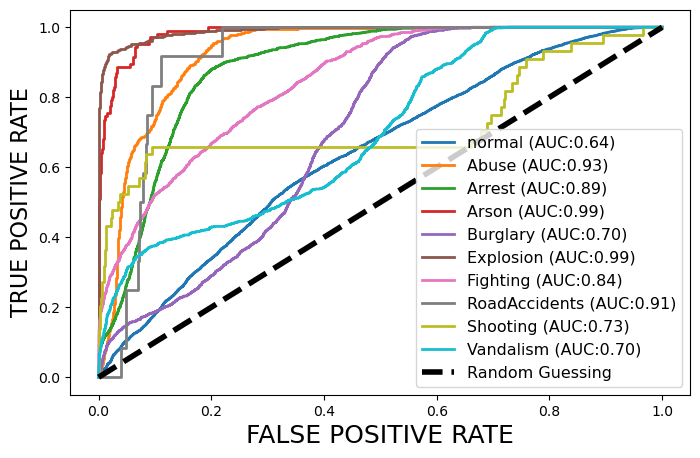

ROC AUC score: 0.8309644515783907


In [181]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [182]:
utils.get_acc_per_lbl(val_pred, y_val)

0, presc 0.71, recall 0.84, f1 0.77	 total 12895 Normal
1, presc 0.23, recall 0.28, f1 0.25	 total 646 Abuse
2, presc 0.61, recall 0.10, f1 0.16	 total 1321 Arrest
3, presc 0.20, recall 0.76, f1 0.31	 total 106 Arson
4, presc 0.20, recall 0.14, f1 0.17	 total 1767 Burglary
5, presc 0.97, recall 0.72, f1 0.83	 total 388 Explosion
6, presc 0.61, recall 0.21, f1 0.31	 total 1132 Fighting
7, presc nan, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc 0.06, recall 0.36, f1 0.10	 total 44 Shooting
9, presc 0.35, recall 0.22, f1 0.27	 total 1019 Vandalism


In [183]:
utils.get_acc(val_pred, y_val)

tensor(0.6306)

In [190]:
X_pred = utils.evaluate(X, final, device, batch_size)

In [191]:
utils.get_acc_per_lbl(X_pred, y)

0, presc 0.96, recall 0.92, f1 0.94	 total 84684 Normal
1, presc 0.64, recall 0.80, f1 0.71	 total 2593 Abuse
2, presc 0.91, recall 0.97, f1 0.94	 total 10454 Arrest
3, presc 0.89, recall 0.94, f1 0.91	 total 4984 Arson
4, presc 0.88, recall 0.96, f1 0.92	 total 8211 Burglary
5, presc 0.83, recall 0.88, f1 0.85	 total 2138 Explosion
6, presc 0.78, recall 0.88, f1 0.83	 total 6178 Fighting
7, presc 0.80, recall 0.31, f1 0.45	 total 689 RoadAccidents
8, presc 0.59, recall 0.69, f1 0.64	 total 1568 Shooting
9, presc 0.74, recall 0.86, f1 0.79	 total 2646 Vandalism


In [192]:
utils.get_acc(X_pred, y)

tensor(0.9135)

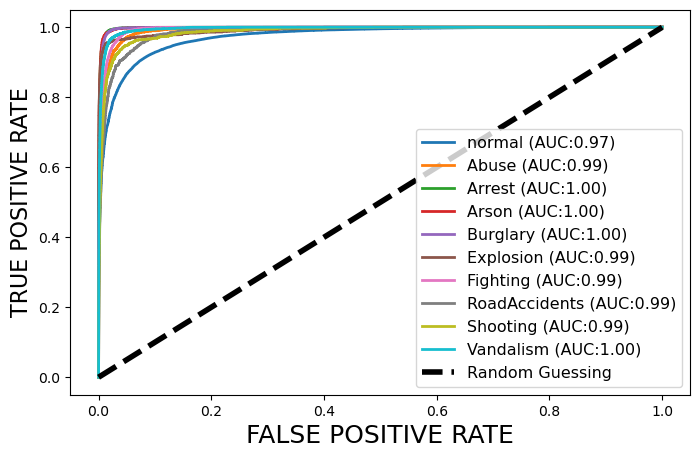

ROC AUC score: 0.9913800088645607


In [193]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y , X_pred, average = "macro"))

In [194]:
torch.save(model.state_dict(), "models/model_image_lavis_features.pt")